In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import scikit_posthocs as sp
from itertools import combinations
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-liwc-proportional.pkl")
features = df.columns[-64:].tolist()

In [3]:
# 1) Prepare data & groups
df['group'] = (
    df['sex'].map({'Feminino':'Female','Masculino':'Male'}).astype(str) + '_' +
    np.where(df['adhd_diagnosis']=="Sim, diagnosticado", 'ADHD',
        np.where(df['adhd_diagnosis'].isin(["Suspeito que tenho", "Estou em processo de diagnóstico"]), 'SuspectADHD', 'noADHD')
    )
)
groups = df['group'].unique().tolist()

In [4]:
# number of participants in each group
group_counts = df['group'].value_counts()
print("Group counts:")
print(group_counts)

Group counts:
group
Female_noADHD         45
Male_noADHD           40
Female_SuspectADHD    31
Female_ADHD           23
Male_SuspectADHD      11
Male_ADHD             10
Name: count, dtype: int64


In [5]:
# 2) Permutation Welch ANOVA (as before)
def perm_anova_F(feat, group_col='group', n_perm=5000):
    obs = pg.welch_anova(dv=feat, between=group_col, data=df)
    f_obs = obs.at[0, 'F']
    perm_F = []
    for _ in range(n_perm):
        shuffled = np.random.permutation(df[group_col].values)
        perm_df = df.assign(_grp=shuffled)
        res = pg.welch_anova(dv=feat, between='_grp', data=perm_df)
        perm_F.append(res.at[0, 'F'])
    p_perm = (np.sum(np.array(perm_F) >= f_obs) + 1) / (n_perm + 1)
    return f_obs, p_perm

In [6]:
# 3) Omnibus tests per feature
omni_rows = []
for feat in features:
    # a) Covariate‐adjusted ANOVA
    null = smf.ols(f"{feat} ~ age + education + word_count", data=df).fit()
    full = smf.ols(f"{feat} ~ C(group) + age + education + word_count", data=df).fit()
    an3 = anova_lm(full, typ=3)
    F_adj = an3.loc['C(group)', 'F']
    p_raw = an3.loc['C(group)', 'PR(>F)']
    # b) Permutation
    _, p_perm = perm_anova_F(feat)
    # c) Kruskal–Wallis
    samples = [g[feat].dropna() for _, g in df.groupby('group')]
    H, p_kw = stats.kruskal(*samples)
    # d) Bayes factor via BIC
    bf10 = np.exp((null.bic - full.bic) / 2)
    omni_rows.append({
        'feature': feat, 'F_adj': F_adj, 'p_adj_raw': p_raw,
        'p_perm': p_perm, 'H': H, 'p_kw': p_kw, 'BF10': bf10
    })
omni_df = pd.DataFrame(omni_rows)
omni_df['p_adj_fdr'] = multipletests(omni_df['p_adj_raw'], method='fdr_bh')[1]
omni_df['p_kw_fdr']  = multipletests(omni_df['p_kw'],      method='fdr_bh')[1]
omni_df = omni_df.sort_values('p_adj_raw')
# Keep top 5 for post‐hoc
top5 = omni_df.head(5)['feature'].tolist()

In [7]:
# 4) Residualize features
resid_df = df.copy()
for feat in features:
    m = smf.ols(f"{feat} ~ age + education + word_count", data=df).fit()
    resid_df[feat] = m.resid

In [8]:
# 5) Games–Howell contrasts & effect sizes for top features
def hedges_g(x, y):
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    s_p = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2)/(nx+ny-2))
    g = (x.mean() - y.mean())/s_p
    return g*(1 - 3/(4*(nx+ny)-9))

def bootstrap_ci(x, y, statfunc, n_boot=2000, ci=95):
    vals = []
    for _ in range(n_boot):
        bx, by = resample(x), resample(y)
        vals.append(statfunc(bx, by))
    return np.percentile(vals, (100-ci)/2), np.percentile(vals, 100-(100-ci)/2)

In [9]:
pairs = list(combinations(groups, 2))
posthoc = {}
for feat in top5:
    gh = pg.pairwise_gameshowell(dv=feat, between='group', data=resid_df)
    gh['p_fdr'] = multipletests(gh['pval'], method='fdr_bh')[1]
    es = []
    for A, B in pairs:
        x = resid_df.loc[resid_df.group == A, feat].dropna().values
        y = resid_df.loc[resid_df.group == B, feat].dropna().values
        g = hedges_g(x, y)
        lo, hi = bootstrap_ci(x, y, hedges_g)
        es.append({'A': A, 'B': B, 'g': g, 'ci_lower': lo, 'ci_upper': hi})
    posthoc[feat] = {'games_howell': gh, 'effect_sizes': pd.DataFrame(es)}

In [10]:
# 6) Dunn’s test on residuals
dunn_tests = {}
for feat in top5:
    dunn = sp.posthoc_dunn(resid_df, val_col=feat, group_col='group', p_adjust='fdr_bh')
    dunn_tests[feat] = dunn


### additional analyses

In [11]:
# 7a) Assumption checks
def assumption_checks(feature):
    samples = [df[df.group == g][feature].dropna() for g in groups]
    levene_p = stats.levene(*samples, center='median').pvalue
    model = smf.ols(f"{feature} ~ C(group) + age + education + word_count", data=df).fit()
    shapiro_p = stats.shapiro(model.resid)[1]
    infl = OLSInfluence(model)
    cooks = infl.cooks_distance[0]
    n_high = np.sum(cooks > 4/len(df))
    return {'levene_p': levene_p, 'shapiro_p': shapiro_p, 'n_high_cook': n_high}
assump = {feat: assumption_checks(feat) for feat in top5}

In [12]:
# 7b) MANOVA & PCA
man = MANOVA(endog=df[features], exog=pd.get_dummies(df['group'], drop_first=True))
manova_res = man.mv_test()

# PCA
pca = PCA(n_components=5)
df_pca = df.dropna(subset=features)
pcs = pca.fit_transform(df_pca[features])
for i in range(5): df_pca[f'PC{i+1}'] = pcs[:, i]
pc1_anova = pg.welch_anova(dv='PC1', between='group', data=df_pca)

In [17]:
# make education numeric
df_numeric = df.copy()
print(df_numeric['education'].unique())
edu_map = {'Ensino secundário': 1, 'Licenciatura': 2, 'Pós-Graduação': 3, 'Mestrado': 4, 'Doutoramento': 5}
df_numeric['education'] = df_numeric['education'].map(edu_map).astype(int)
print(df_numeric['education'].unique())

['Licenciatura', 'Mestrado', 'Ensino secundário', 'Doutoramento', 'Pós-Graduação']
Categories (5, object): ['Doutoramento', 'Ensino secundário', 'Licenciatura', 'Mestrado', 'Pós-Graduação']
[2 4 1 5 3]


In [18]:
# 7c) Rank ANCOVA
df_rank = df_numeric.copy()
rank_ancova = {}
for feat in features:
    # rank-transform feature
    df_rank[f'{feat}_rank'] = df_rank[feat].rank()
    res = pg.ancova(data=df_rank, dv=f'{feat}_rank', covar=['age','education','word_count'], between='group')
    rank_ancova[feat] = res

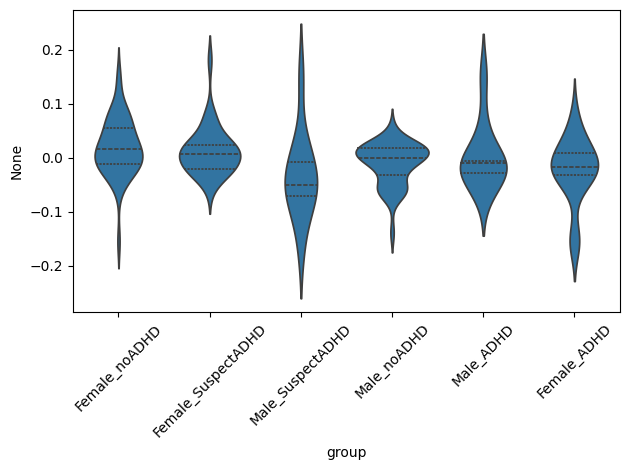

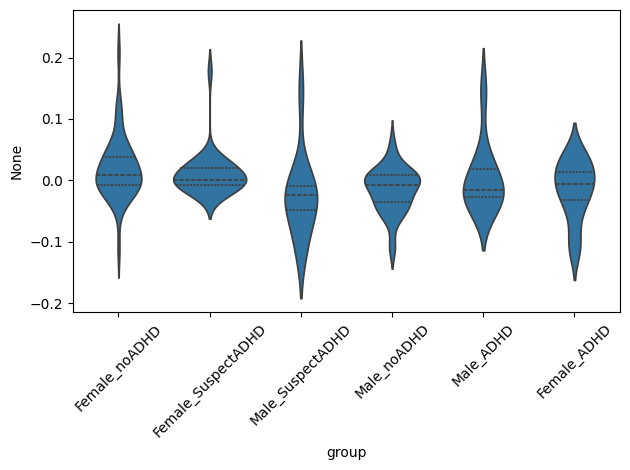

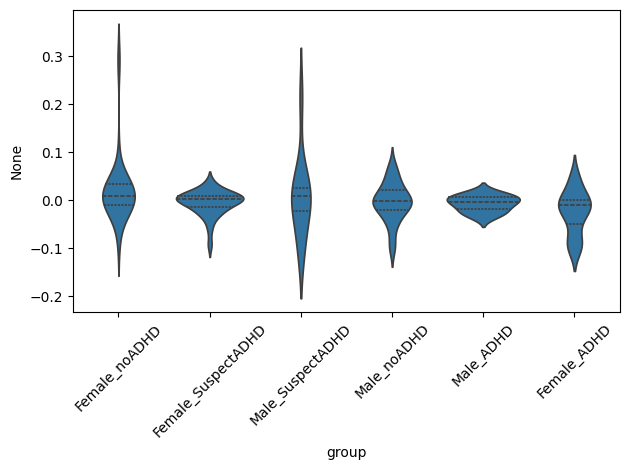

In [19]:
# 7d) Visualizations
import seaborn as sns
from sklearn.utils import resample

def plot_residuals(feat):
    mdl = smf.ols(f"{feat} ~ age + education + word_count", data=df_numeric).fit()
    resid = mdl.resid
    plt.figure()
    sns.violinplot(x=df_numeric['group'], y=resid, inner='quartile')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
for feat in top5[:3]: plot_residuals(feat)

In [20]:
# 7e) Bootstrap ANCOVA F CI

def bootstrap_ancova(feat, n_boot=1000):
    Fs = []
    for _ in range(n_boot):
        samp = df_numeric.sample(frac=1, replace=True)
        mod = smf.ols(f"{feat} ~ C(group) + age + education + word_count", data=samp).fit()
        Fs.append(anova_lm(mod, typ=3).loc['C(group)', 'F'])
    return np.percentile(Fs, [2.5, 97.5])
ci_boot = {feat: bootstrap_ancova(feat) for feat in top5}

### print results

In [21]:
# Omnibus summary (top 5 features)
print("=== Omnibus ANOVA (top 5) ===")
print(omni_df[['feature','F_adj','p_adj_raw','p_adj_fdr','p_perm','BF10']].head(5).to_markdown(index=False))

=== Omnibus ANOVA (top 5) ===
| feature   |   F_adj |   p_adj_raw |   p_adj_fdr |     p_perm |       BF10 |
|:----------|--------:|------------:|------------:|-----------:|-----------:|
| pronoun   | 4.04016 |  0.00182163 |   0.0655123 | 0.0113977  | 0.0861006  |
| ppron     | 3.97893 |  0.00204726 |   0.0655123 | 0.00179964 | 0.0744235  |
| space     | 3.01561 |  0.012715   |   0.22223   | 0.0969806  | 0.00725109 |
| funct     | 2.86538 |  0.0168475  |   0.22223   | 0.162967   | 0.00501191 |
| negate    | 2.83828 |  0.0177222  |   0.22223   | 0.0265947  | 0.004688   |


In [22]:
# Post-hoc Games-Howell and effect sizes
for feat in top5:
    print(f"--- Post-hoc for {feat} ---")
    print("Games-Howell:")
    print(posthoc[feat]['games_howell'][['A','B','T','pval','p_fdr']].round(3).to_markdown(index=False))
    print("Effect sizes (Hedges' g + 95% CI):")
    print(posthoc[feat]['effect_sizes'].round(3).to_markdown(index=False))


--- Post-hoc for pronoun ---
Games-Howell:
| A                  | B                  |      T |   pval |   p_fdr |
|:-------------------|:-------------------|-------:|-------:|--------:|
| Female_ADHD        | Female_SuspectADHD | -2.642 |  0.11  |   0.551 |
| Female_ADHD        | Female_noADHD      | -2.952 |  0.054 |   0.414 |
| Female_ADHD        | Male_ADHD          | -1.13  |  0.862 |   0.999 |
| Female_ADHD        | Male_SuspectADHD   |  0.426 |  0.998 |   0.999 |
| Female_ADHD        | Male_noADHD        | -1.04  |  0.901 |   0.999 |
| Female_SuspectADHD | Female_noADHD      | -0.365 |  0.999 |   0.999 |
| Female_SuspectADHD | Male_ADHD          |  0.671 |  0.982 |   0.999 |
| Female_SuspectADHD | Male_SuspectADHD   |  1.985 |  0.401 |   0.999 |
| Female_SuspectADHD | Male_noADHD        |  2.423 |  0.166 |   0.621 |
| Female_noADHD      | Male_ADHD          |  0.881 |  0.944 |   0.999 |
| Female_noADHD      | Male_SuspectADHD   |  2.157 |  0.322 |   0.965 |
| Female_noADHD      

In [23]:
# Dunn's tests
print("=== Dunn's tests ===")
for feat in top5:
    print(f"Dunn's for {feat}:")
    print(dunn_tests[feat].round(3).to_markdown())

=== Dunn's tests ===
Dunn's for pronoun:
|                    |   Female_ADHD |   Female_SuspectADHD |   Female_noADHD |   Male_ADHD |   Male_SuspectADHD |   Male_noADHD |
|:-------------------|--------------:|---------------------:|----------------:|------------:|-------------------:|--------------:|
| Female_ADHD        |         1     |                0.058 |           0.021 |       0.759 |              0.449 |         0.477 |
| Female_SuspectADHD |         0.058 |                1     |           0.759 |       0.246 |              0.021 |         0.159 |
| Female_noADHD      |         0.021 |                0.759 |           1     |       0.159 |              0.017 |         0.058 |
| Male_ADHD          |         0.759 |                0.246 |           0.159 |       1     |              0.41  |         0.759 |
| Male_SuspectADHD   |         0.449 |                0.021 |           0.017 |       0.41  |              1     |         0.159 |
| Male_noADHD        |         0.477 |    

In [24]:
# Assumption checks
print("=== Assumption Checks (top features) ===")
for feat, res in assump.items():
    print(f"{feat}: Levene p={res['levene_p']:.3f}, Shapiro p={res['shapiro_p']:.3f}, High Cook's={res['n_high_cook']}")

=== Assumption Checks (top features) ===
pronoun: Levene p=0.334, Shapiro p=0.000, High Cook's=10
ppron: Levene p=0.302, Shapiro p=0.000, High Cook's=15
space: Levene p=0.056, Shapiro p=0.000, High Cook's=9
funct: Levene p=0.008, Shapiro p=0.000, High Cook's=12
negate: Levene p=0.474, Shapiro p=0.000, High Cook's=5


In [25]:
# MANOVA result summary
print("=== MANOVA ===")
print(manova_res)

=== MANOVA ===
                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value   Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.2487 64.0000 92.0000  4.3428 0.0000
         Pillai's trace 0.7513 64.0000 92.0000  4.3428 0.0000
 Hotelling-Lawley trace 3.0211 64.0000 92.0000  4.3428 0.0000
    Roy's greatest root 3.0211 64.0000 92.0000  4.3428 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
           x1           Value   Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.1749 64.0000 92.0000  6.7819 0.0000
         Pillai's trace 0.8251 64.0000 92.0000  6.7819 0.0000
 Hotelling-

In [26]:
# PCA -> PC1 ANOVA
print("=== PCA PC1 ANOVA ===")
print(pc1_anova)

=== PCA PC1 ANOVA ===
  Source  ddof1      ddof2         F     p-unc       np2
0  group      5  44.607964  2.899916  0.023741  0.091997


In [27]:
# Rank-ANCOVA on top features
print("=== Rank-based ANCOVA (top features) ===")
for feat in top5:
    print(f"{feat}:")
    print(rank_ancova[feat])

=== Rank-based ANCOVA (top features) ===
pronoun:
       Source             SS   DF         F     p-unc       np2
0       group   37564.424067    5  4.043952  0.001793  0.118092
1         age    9890.900409    1  5.323963  0.022393  0.034057
2   education    2301.225409    1  1.238678  0.267495  0.008136
3  word_count    5269.341051    1  2.836322  0.094221  0.018437
4    Residual  280528.983551  151       NaN       NaN       NaN
ppron:
       Source             SS   DF         F     p-unc       np2
0       group   43629.862762    5  4.566054  0.000660  0.131337
1         age    1799.025793    1  0.941379  0.333475  0.006196
2   education    7106.898594    1  3.718838  0.055678  0.024036
3  word_count       3.771350    1  0.001973  0.964626  0.000013
4    Residual  288569.078056  151       NaN       NaN       NaN
space:
       Source             SS   DF         F     p-unc       np2
0       group   19528.270072    5  1.934139  0.091862  0.060190
1         age     207.107297    1  0.102

In [28]:
# Bootstrap F CI
print("=== Bootstrap ANCOVA F 95% CI ===")
for feat, ci in ci_boot.items():
    print(f"{feat}: {ci[0]:.2f} to {ci[1]:.2f}")


=== Bootstrap ANCOVA F 95% CI ===
pronoun: 1.65 to 10.56
ppron: 2.02 to 9.83
space: 1.04 to 6.90
funct: 1.02 to 7.61
negate: 1.45 to 8.16
